# Прогнозирование продаж магазина Лента, модель Arima для временного ряда 
## Данные по четырем файлам:
1) sales_df_train.csv –данные по продажам за скользящий год для обучения. 
Столбцы: 
- st_id – захэшированное id магазина;
- pr_sku_id – захэшированное id товара;
- date – дата;
- pr_sales_type_id – флаг наличия промо;
- pr_sales_in_units – число проданных товаров всего (промо и без);
- pr_promo_sales_in_units – число проданных товаров с признаком промо;
- pr_sales_in_rub – продажи в РУБ всего (промо и без)
- pr_promo_sales_in_rub – продажи с признаком промо в РУБ; 

2) pr_df.csv – данные по товарной иерархии. 
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
Столбцы: 
- pr_group_id – захэшированная группа товара; 
- pr_cat_id – захэшированная категория товара; 
- pr_subcat_id – захэшированная подкатегория товара;
- pr_sku_id – захэшированное id товара;
- pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).

3) pr_st.csv – данные по магазинам. 
Столбцы: 
- st_id – захэшированное id магазина;
- st_city_id – захэшированное id города;
- st_division_code id – захэшированное id дивизиона;
- st_type_format_id – id формата магазина; 
- st_type_loc_id – id тип локации/окружения магазина;
- st_type_size_id – id типа размера магазина;
- st_is_active – флаг активного магазина на данный момент.

4) sales_submission.csv – пример файла с результатом работы модели прогноза спроса. 
Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по 
умолчанию колонка заполнена нулями). 
Столбцы: 
- st_id – захэшированное id магазина; 
- pr_sku_id – захэшированное id товара;
- date – дата (день);
- target – спрос в ШТ
## Бизнес задача:
Магазину Лента нужна модель, которая будет предсказывать сколько нужно приготовить продукции отдела собественной кулинарии на 14 дней вперед. Магазину нужно заранее быть готовым, чтобы иметь необходимые ингридиенты, а так же в идеале иметь меньше выброшенных некупленных товаров. 

## План действий:
- загрузка и ознакомление с данными
- обработка выбросов, поиск аномалий
- создание новый признаков (по возможности)
- подготовка признаков для анализа
- построение модели Arima
- тестирование Arima и получение WAPE по формуле
- общий выовод по модели

## Загрузка и анализ данных

In [1]:
import pandas as pd
import numpy as np
import phik
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
plt.rcParams["figure.figsize"] = (16,8)
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [2]:
sales_df_train = pd.read_csv('sales_df_train.csv')
pr_df = pd.read_csv('pr_df.csv')
pr_st = pd.read_csv('st_df.csv')
holidays = pd.read_csv('holidays_covid_calendar.csv')

Посмотрим содержимое наших файлов

In [3]:
holidays.head(5) # загрузили вспомогательный файл празников

,year,day,weekday,date,calday,holiday,covid
0,2015,1,4,01.01.2015,20150101,1,0
1,2015,2,5,02.01.2015,20150102,1,0
2,2015,3,6,03.01.2015,20150103,1,0
3,2015,4,7,04.01.2015,20150104,1,0
4,2015,5,1,05.01.2015,20150105,1,0


In [4]:
holidays.info() # date имеет тип строки

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB


In [5]:
holidays['date'] = pd.to_datetime(holidays['date'], format="%d.%m.%Y") # преобразуем даты

In [6]:
holiday = holidays[['date','holiday']] # нам нужны только маркировки праздников, остальное лишнее
holiday.head(5)

,date,holiday
0,2015-01-01,1
1,2015-01-02,1
2,2015-01-03,1
3,2015-01-04,1
4,2015-01-05,1


In [7]:
sales_df_train.head(5) # загрузим наш основной файл

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [8]:
sales_df_train.info() # даты заданы как строки, нужно будет устранить это

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


In [9]:
sales_df_train['date'] = pd.to_datetime(sales_df_train['date']) # преобразуем даты

In [10]:
sales_df_train['date'] # проверка

0        2022-10-20
1        2023-01-29
2        2023-03-02
3        2023-04-05
4        2023-02-17
            ...    
883010   2022-12-13
883011   2023-04-18
883012   2022-08-16
883013   2023-04-23
883014   2023-01-19
Name: date, Length: 883015, dtype: datetime64[ns]

In [11]:
# добавим "флажек" праздников по датам из нашей выборки
sales_df_train = sales_df_train.merge(holiday, on='date', how='left')

In [12]:
sales_df_train['st_id'].value_counts() # 12 разных наименований магазинов

st_id
c81e728d9d4c2f636f067f89cc14862c    174687
16a5cdae362b8d27a1d8f8c7b78b4330    157542
42a0e188f5033bc65bf8d78622277c4e    140286
f7e6c85504ce6e82442c770f7c8606f0    124145
6364d3f0f495b6ab9dcf8d3b5c6e0b01    115830
fa7cdfad1a5aaf8370ebeda47a1ff1c3    110537
1ecfb463472ec9115b10c292ef8bc986     47404
53e19f3dbb211f20b20b45668303c1b6      9231
bd470ca955d9497bbcb808e59952fffc      2586
1aa057313c28fa4a40c5bc084b11d276       719
084a8a9aa8cced9175bd07bc44998e75        38
62f91ce9b820a491ee78c108636db089        10
Name: count, dtype: int64

In [13]:
sales_df_train['pr_sku_id'].value_counts() # 1991 разных товара

pr_sku_id
62d4af457ba2540ce0898a211c0cd17a    4424
ced0c1a84924c982a6403870c54b99ca    4362
cf91eca9321c9c272fb4e7cf4bcc6a43    4213
5b26f85ccb23039364226f66f0366c66    3982
6b1344097385a42484abd4746371e416    3929
                                    ... 
8878e97692da06941dedcf44c1f50668       1
e18fadbb06e89f6f03545537c02b8bee       1
a4f2ee628051a3b73d6e1003ff6eaa5b       1
e65002dccbd12e07c33815a27e72a6cd       1
3a0babb7888bd5976ce3df45743615af       1
Name: count, Length: 1991, dtype: int64

In [14]:
pr_df.head(5)

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17


In [15]:
pr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [16]:
pr_df['pr_sku_id'].value_counts() # 2050 уникальных товара, в то время как в продаже 1991 из них

pr_sku_id
fd064933250b0bfe4f926b867b0a5ec8    1
da74b0abdd41cdf458afd0dfebf8c251    1
b57b9a839378f969db586df10679d53b    1
b1cef50685daf98378285905bf554e8c    1
be271ebec86ed632d4d59ca0b7a5c072    1
                                   ..
e644b4306f7ecd4d5158ac0179db76a5    1
8146f98d564daf7f6cc87d9edcb92705    1
b77bf3cb7967619f5b3d226d63dae631    1
2d5d5ab212f4c4e7498f31ca7d77edbd    1
dbfce512dcdabc6b6e2724b6ec44efda    1
Name: count, Length: 2050, dtype: int64

In [17]:
pr_df['pr_group_id'].value_counts() # 9 разных групп товаров

pr_group_id
c74d97b01eae257e44aa9d5bade97baf    806
aab3238922bcc25a6f606eb525ffdc56    717
6512bd43d9caa6e02c990b0a82652dca    203
c51ce410c124a10e0db5e4b97fc2af39    182
c20ad4d76fe97759aa27a0c99bff6710     73
1ff1de774005f8da13f42943881c655f     37
32bb90e8976aab5298d5da10fe66f21d     27
98f13708210194c475687be6106a3b84      4
3c59dc048e8850243be8079a5c74d079      1
Name: count, dtype: int64

In [18]:
pr_df['pr_cat_id'].value_counts() # 43 разных категории товаров

pr_cat_id
c559da2ba967eb820766939a658022c8    265
9701a1c165dd9420816bfec5edd6c2b1    222
1bc0249a6412ef49b07fe6f62e6dc8de    211
28fc2782ea7ef51c1104ccf7b9bea13d    167
46771d1f432b42343f56f791422a4991    112
f3173935ed8ac4bf073c1bcd63171f8a    111
e58cc5ca94270acaceed13bc82dfedf7     99
a368b0de8b91cfb3f91892fbf1ebd4b2     88
3de2334a314a7a72721f1f74a6cb4cee     79
fb2fcd534b0ff3bbed73cc51df620323     72
535ab76633d94208236a2e829ea6d888     61
b7087c1f4f89e63af8d46f3b20271153     43
7a6a74cbe87bc60030a4bd041dd47b78     42
b59c67bf196a4758191e42f76670ceba     39
a6ea8471c120fe8cc35a2954c9b9c595     37
faafda66202d234463057972460c04f5     33
c9f95a0a5af052bffce5c89917335f67     33
fd5c905bcd8c3348ad1b35d7231ee2b1     31
4edaa105d5f53590338791951e38c3ad     31
5caf41d62364d5b41a893adc1a9dd5d4     30
6d9c547cf146054a5a720606a7694467     25
186a157b2992e7daed3677ce8e9fe40f     25
a14ac55a4f27472c5d894ec1c3c743d2     21
f18a6d1cde4b205199de8729a6637b42     20
f9ab16852d455ce9203da64f4fc7f9

In [19]:
pr_df['pr_subcat_id'].value_counts() # 170 подкатегорий

pr_subcat_id
8feef08314d477a5b68ba18a6d35819d    72
c01c475ac8d447730ece97d846cc4f25    60
0f3abfd67959c079e7b3759440e7415c    49
41b1d51c9e3ba9a263361f9cfa0eb434    48
c93c26cd49ea08e6b8984351d4164575    48
                                    ..
9d8f103e98545ee0e66801f0699110bf     1
858da246521bcdc8490ff01828e36f22     1
bb44cd485a19a2b227b3ccc473d10302     1
2a5b7197a4980fa272ebe4822ce9d95a     1
bd64a7fd410708f485412e9feabefde9     1
Name: count, Length: 170, dtype: int64

In [20]:
pr_df['pr_uom_id'].value_counts() # весовые и количественные измерения товара

pr_uom_id
1     1279
17     771
Name: count, dtype: int64

In [21]:
pr_st.head(13)

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
5,53e19f3dbb211f20b20b45668303c1b6,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,20,1
6,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
7,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
8,fa7cdfad1a5aaf8370ebeda47a1ff1c3,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
9,f7e6c85504ce6e82442c770f7c8606f0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1


In [22]:
pr_st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


У меня есть 3 таблицы. 1 - продажи, 2 - товары, 3 - города. Первая таблица в моем понимании будет как базовая, новые признаки которые я буду создавать на основе других таблиц я буду передвать в первую. А дальше на ее основе будем анализировать корреляцию признаков и строить модель машинного обучения.

In [23]:
merged_df = sales_df_train.merge(pr_st, on='st_id', how='left')
merged_df = merged_df.merge(pr_df, on='pr_sku_id', how='left')
#merged_df = merged_df.set_index('date')
merged_df.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,holiday,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0,0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0,0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0,0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1


In [24]:
merged_df.isna().sum() # пропусков нет

st_id                      0
pr_sku_id                  0
date                       0
pr_sales_type_id           0
pr_sales_in_units          0
pr_promo_sales_in_units    0
pr_sales_in_rub            0
pr_promo_sales_in_rub      0
holiday                    0
st_city_id                 0
st_division_code           0
st_type_format_id          0
st_type_loc_id             0
st_type_size_id            0
st_is_active               0
pr_group_id                0
pr_cat_id                  0
pr_subcat_id               0
pr_uom_id                  0
dtype: int64

In [25]:
merged_df.describe() # отрицательные значения скорее всего возвраты, они мне не пригодятся для пргнозирования спроса

,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,holiday,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_uom_id
count,883015,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000
mean,2023-01-25 18:19:37.852697600,0.406486,5.037956,2.230010,596.705181,294.766561,0.332137,1.096438,1.206916,11.464332,0.999174,6.751821
min,2022-08-01 00:00:00,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000,0.000000,1.000000,1.000000,8.000000,0.000000,1.000000
25%,2022-10-29 00:00:00,0.000000,1.000000,0.000000,98.000000,0.000000,0.000000,1.000000,1.000000,8.000000,1.000000,1.000000
50%,2023-01-27 00:00:00,0.000000,2.000000,0.000000,224.000000,0.000000,0.000000,1.000000,1.000000,12.000000,1.000000,1.000000
75%,2023-04-25 00:00:00,1.000000,4.000000,1.000000,540.000000,127.000000,1.000000,1.000000,1.000000,12.000000,1.000000,17.000000
max,2023-07-18 00:00:00,1.000000,2348.000000,2348.000000,183265.000000,183265.000000,1.000000,4.000000,3.000000,32.000000,1.000000,17.000000
std,NaN,0.491178,13.402984,11.063288,1577.366179,1402.764168,0.470980,0.415505,0.438867,4.509462,0.028721,7.677614


Мы получили представление о данных, как они распределные, о пропусках и аномалиях. Теперь мы можем приступить к подготовке признаков на обучение. 

## Подготовка признаков 

In [26]:
# срез по не отрицательным значениям и активным магазинам
merged_df_cleared = merged_df.query('pr_promo_sales_in_units>=0 and pr_sales_in_rub>=0 and st_is_active==1').copy()

In [27]:
# срез по выбросам где есть продажи но нет денег и наоборот
merged_df_cleared = merged_df_cleared.query('not (pr_sales_in_units==0 and pr_sales_in_rub!=0)')
merged_df_cleared = merged_df_cleared.query('not (pr_sales_in_units!=0 and pr_sales_in_rub==0)')

In [28]:
# получаем среднюю цену по товару
merged_df_cleared['price_per_unit'] = merged_df_cleared['pr_sales_in_rub']/merged_df_cleared['pr_sales_in_units']

In [29]:
# мы не можем прогнозировать промо акции, поэтому создадим срез без них
merged_df_cleared_no_promo = merged_df_cleared.query('pr_sales_type_id==0').copy()

In [30]:
# сгруппирую данные чтобы увидеть топ 100 продаваемых товаров
sales_by_product = merged_df_cleared_no_promo.groupby('pr_sku_id').agg({'pr_sales_in_units': 'sum'})

In [31]:
# результат группировки
sales_by_product_sorted = sales_by_product.sort_values('pr_sales_in_units', ascending=False)
sales_by_product_sorted

,pr_sales_in_units
pr_sku_id,
62d4af457ba2540ce0898a211c0cd17a,104052.0
c0e3f3bd815a862433bc3399c487926b,96023.0
ced0c1a84924c982a6403870c54b99ca,80923.0
d5bfeecaaa47887a4b92d17fa55c2e18,70964.0
cf91eca9321c9c272fb4e7cf4bcc6a43,50858.0
...,...
4172b50d25db3ddf079d4704d4070779,1.0
9187804cff28313f604012414525ba2d,1.0
421136a4b7d3f3ea5fb5b0dcc8da0888,1.0


Для начала я попробую взять топ 25 товаров. Если модель будет успешно работать то будем увеличивать планку. 

In [32]:
# сохранил топ 25
top_25_products = sales_by_product_sorted.head(25)

In [33]:
# теперь оставим в изначальной таблице топ 25 товаров
result = pd.merge(merged_df_cleared_no_promo, top_25_products, on='pr_sku_id')

In [34]:
result.columns # для удобства выведу значения

Index(['st_id', 'pr_sku_id', 'date', 'pr_sales_type_id', 'pr_sales_in_units_x',
       'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub',
       'holiday', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'st_is_active', 'pr_group_id',
       'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'price_per_unit',
       'pr_sales_in_units_y'],
      dtype='object')

In [35]:
final_df = result[['st_id', 'pr_sku_id', 'pr_sales_in_units_x', 'price_per_unit', 'holiday', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'pr_group_id',
       'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'date']].copy()

In [36]:
# не так уж много пропусков, мы заполним продажи популярных товаров медианным значеним, так как скорее всего не было сырья
final_df.query('pr_sales_in_units_x==0')

,st_id,pr_sku_id,pr_sales_in_units_x,price_per_unit,holiday,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,date
18568,42a0e188f5033bc65bf8d78622277c4e,ced0c1a84924c982a6403870c54b99ca,0.0,NaN,0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,2023-02-07
30401,fa7cdfad1a5aaf8370ebeda47a1ff1c3,2e463fcb1369be4d5dfbe87e04f60df2,0.0,NaN,0,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,b9d194b4fcd411b02eea6fe9f66bf427,1,2023-04-14


In [37]:
# заменим значения 0 в столбце 'pr_sales_in_units_x' на медианные значения по группе 'pr_sku_id'
final_df['pr_sales_in_units_x'] = final_df.groupby('pr_sku_id')['pr_sales_in_units_x'].transform(lambda x: x.replace(0, np.nan).fillna(x.median()))

In [38]:
# тоже самое для пропусков в price_per_unit
final_df['price_per_unit'] = final_df.groupby('pr_sku_id')['price_per_unit'].transform(lambda x: x.fillna(x.median()))

In [39]:
final_df.head(5)

,st_id,pr_sku_id,pr_sales_in_units_x,price_per_unit,holiday,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,date
0,6364d3f0f495b6ab9dcf8d3b5c6e0b01,dfb085b0647b9ee8ce010670d1e30ab6,2.0,19.000000,0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,2023-01-30
1,c81e728d9d4c2f636f067f89cc14862c,dfb085b0647b9ee8ce010670d1e30ab6,4.0,23.500000,0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,2022-12-20
2,c81e728d9d4c2f636f067f89cc14862c,dfb085b0647b9ee8ce010670d1e30ab6,5.0,22.600000,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,2022-11-19
3,42a0e188f5033bc65bf8d78622277c4e,dfb085b0647b9ee8ce010670d1e30ab6,7.0,23.142857,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,2023-06-17
4,6364d3f0f495b6ab9dcf8d3b5c6e0b01,dfb085b0647b9ee8ce010670d1e30ab6,9.0,20.888889,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,2022-12-04


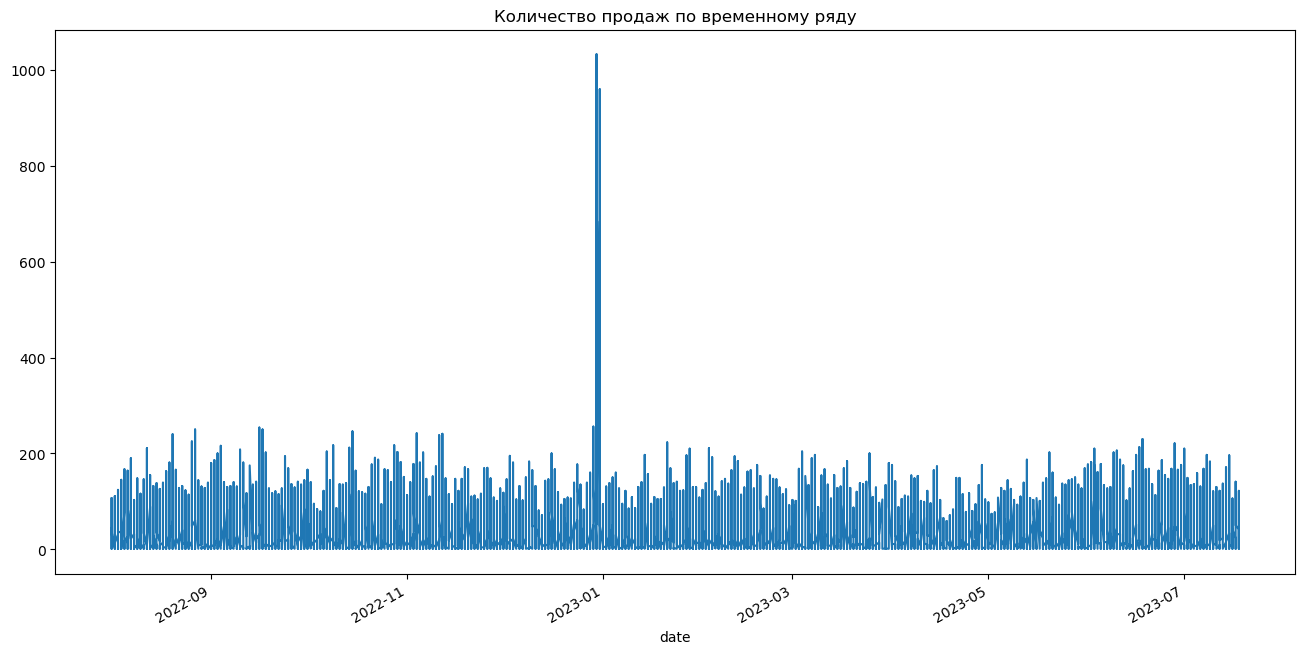

In [40]:
# построим график чтобы посомтреть на наш временной ряд
final_df.set_index('date')['pr_sales_in_units_x'].plot()
plt.title('Количество продаж по временному ряду')
plt.show()

In [41]:
#phik_overview = final_df_grouped.phik_matrix(interval_cols=['pr_sales_in_units_x', 'price_per_unit'])
#phik_overview

In [42]:
#plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
#                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
#                        figsize=(15,15))
#plt.tight_layout()

In [43]:
final_df.columns

Index(['st_id', 'pr_sku_id', 'pr_sales_in_units_x', 'price_per_unit',
       'holiday', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'pr_group_id', 'pr_cat_id',
       'pr_subcat_id', 'pr_uom_id', 'date'],
      dtype='object')

Промежуточный вывод:

Мы провели подготовку данных. В ходе работы, были добавлены новые признаки как holidays, или цена за единицу товара. Исходя из логики что у самых популярных товаров не могут быть дни с нулевыми продажами мы заполнили такие дни медианой. Я объединил все датаесеты в 1 , чтобы получить как можно больше признаков, выделил топ 25 по продажам для анализа. Так же построили график продаж по временному ряду на котором виден один всплеск на Новый Год и остальные дни выглядят стационарно. Далее мы с коллегами решили использовать разные модели, чтобы охватить больше вариантов решений. Я буду заниматься аримой. 

## Модель ARIMA

Перед созданием модели я внимательно ознакомлюсь с файлом по которому от нас ждут результат. Мой результат должен выглядеть точно так же. Задача спрогнозировать 14 дней с 19.07.2023 по 01.08.2023 включительно. 

In [44]:
# загрузка примера вычислений
sales_submission = pd.read_csv('sales_submission.csv')
sales_submission.head(5)

,st_id,pr_sku_id,date,target
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,0
1,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,0
2,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,0
3,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,0


In [45]:
# посмотрим даты
sales_submission['date'].value_counts()

date
2023-07-20    3121
2023-07-21    3121
2023-07-22    3121
2023-07-24    3121
2023-07-25    3121
2023-07-26    3121
2023-07-27    3121
2023-07-28    3121
2023-07-19    3121
2023-07-23    3121
2023-07-29    3121
2023-07-30    3121
2023-07-31    3121
2023-08-01    3121
Name: count, dtype: int64

### Создание модели 

In [46]:
# cортировка данных по дате
final_df = final_df.sort_values('date')

In [47]:
%%time
# группировка данных по магазину и артикулу товара
grouped_data = final_df.groupby(['st_id', 'pr_sku_id'])

# создание временного ряда и прогноз для каждой группы
predictions = []
for group, data in grouped_data:
    
    time_series = pd.Series(data['pr_sales_in_units_x'].values, index=pd.to_datetime(data['date'], format='%Y-%m-%d'))

    # построение аримы
    model = pm.auto_arima(time_series)

    # прогноз на следующие 14 дней
    forecast = model.predict(n_periods=14)

    # округление значений прогноза так как нас интересуют штуки
    rounded_forecast = np.round(forecast.values)

    # результаты прогноза
    forecast_df = pd.DataFrame({
        'st_id': [group[0]] * 14,
        'pr_sku_id': [group[1]] * 14,
        'date': pd.date_range(start=pd.to_datetime('2023-07-19'), periods=14).strftime('%Y-%m-%d'),
        'target': rounded_forecast
    })

    predictions.append(forecast_df)

result = pd.concat(predictions)

# сохранение результатов в файл
#result.to_csv('arima_ver_8.csv', index=False)

CPU times: total: 4min 33s
Wall time: 4min 30s


Модель работает очень быстро, практически мгновенно

In [48]:
# посмотрим данные модели
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  315
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -787.183
Date:                Tue, 10 Oct 2023   AIC                           1578.367
Time:                        04:14:55   BIC                           1585.866
Sample:                             0   HQIC                          1581.363
                                - 315                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9227      0.028    -32.730      0.000      -0.978      -0.867
sigma2         8.7579      0.310     28.296      0.000       8.151       9.365
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              1234.48
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             1.85
Prob(H) (two-sided):                  0.18   Kurtosis:                        11.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

А теперь я создам функцию для вызова метрики WAPE. Выделим последние 14 дней для теста и определим WAPE

In [49]:
final_df.columns

Index(['st_id', 'pr_sku_id', 'pr_sales_in_units_x', 'price_per_unit',
       'holiday', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'pr_group_id', 'pr_cat_id',
       'pr_subcat_id', 'pr_uom_id', 'date'],
      dtype='object')

In [50]:
final_df = final_df.drop(['price_per_unit', 'holiday', 'st_city_id', 'st_division_code', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id'], axis=1)

In [51]:
# выделим тестовую выборку как 14 последний дней
last_14_days = pd.to_datetime('2023-07-19') - pd.DateOffset(days=14)
test_data = final_df.loc[final_df['date'] >= last_14_days]

# выделим тренировочную выборку
train_data = final_df.drop(test_data.index)

# группировка тестовой выборки
test_data = test_data.groupby(['st_id', 'pr_sku_id', 'date'])['pr_sales_in_units_x'].sum().reset_index()

# группировка данных по магазину и артикулу товара
train_data = final_df.groupby(['st_id', 'pr_sku_id'])

# создание временного ряда и прогноз для каждой группы
predictions = []
for group, data in grouped_data:
    
    time_series = pd.Series(data['pr_sales_in_units_x'].values, index=pd.to_datetime(data['date'], format='%Y-%m-%d'))

    # построение аримы
    model = pm.auto_arima(time_series)

    # прогноз на следующие 14 дней
    forecast = model.predict(n_periods=14)

    # округление значений прогноза так как нас интересуют штуки
    rounded_forecast = np.round(forecast.values)

    # результаты прогноза
    forecast_df = pd.DataFrame({
        'st_id': [group[0]] * 14,
        'pr_sku_id': [group[1]] * 14,
        'date': pd.date_range(start=pd.to_datetime('2023-07-05'), periods=14).strftime('%Y-%m-%d'),
        'target': rounded_forecast
    })

    predictions.append(forecast_df)

result = pd.concat(predictions)

# создаем метрику WAPE
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

# создаем аргументы для WAPE
actual_sales = np.array(test_data['pr_sales_in_units_x'])
pred = np.array(result['target'])

wape_score = wape(actual_sales[:100], pred[:100])
print(f"WAPE 14 дней: {wape_score}")

WAPE 14 дней: 0.6893814091961628


# Общий вывод по модели Arima:

Магазину Лента нужна модель, которая будет предсказывать сколько нужно приготовить продукции отдела собественной кулинарии на 14 дней вперед. Магазину нужно заранее быть готовым, чтобы иметь необходимые ингридиенты, а так же в идеале иметь меньше выброшенных некупленных товаров.

Для реализации этой задачи был составлен план действий:

- загрузка и ознакомление с данными
- обработка выбросов, поиск аномалий
- создание новый признаков (по возможности)
- подготовка признаков для анализа
- построение модели Arima
- тестирование Arima и получение WAPE по формуле
- общий выовод по модели

1) Мы загрузили и оценили предоставленные нам данные. По ходу анализа с данными мы получили представление о том как выглядят данные, временной ряд, примвели даты в нужый формат, посомтрели как распределены признаки во впременном ряду. Были обнаружены нектороые аномалии, а так же лишние данные, которые мы устранили в дальнейшем.

2) На этапре предобработки мы убрали закрытые не актуальные точки продаж, так же мы выделили топ 25 товаров, и в соотвествии с ними заполнили пропуски и нулевые значения. Так же были составлены новые признаки. Мы объединили таблицы и построили график продаж по временному ряду. 

3) После обработки и подготовки данных я приступил к построению модели Arima. 

Я тестировал разные настройки и конфигурации модели Arima. Как итог на автоматическом подборе папметров я получил метрику WAPE 0.69 для тестовой выборки в 14 дней, время подбора составляет 4 минуты, при том что без автоматического подбора параметров Arima время составляет 4 секунды. Модель не дает высокого качества, но мы можем в двльнейшем использовать ее для прогнозирования цены и передачи ее как признака для другой модели. 